In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Importing necessary
import torch
from torchvision import transforms
from torchvision import datasets
import pandas as pd
import cv2
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.utils.data import Dataset
import numpy as np

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
device='cpu'

In [ ]:
#Getting the paths of data
main_folder="/content/drive/MyDrive/brain_segm/kaggle_3m"
image_mask_dict={}
image_mask_dict["image"]=[]
image_mask_dict["mask"]=[]
for folderr in os.listdir(main_folder):
  folder=os.path.join(main_folder, folderr)
  try:
    for filename in os.listdir(folder):
      if "mask" in filename:
        image_mask_dict["mask"].append(os.path.join(folder, filename))
      else:
        image_mask_dict["image"].append(os.path.join(folder, filename))
  except:
    pass



In [ ]:
#Sorting the directories of images and masks so that each of the masks corresponds to the right image
image_mask_dict["image"]=sorted(image_mask_dict["image"], key=lambda x: x[:-4])
image_mask_dict["mask"]=sorted(image_mask_dict["mask"], key=lambda x: x[:-9])

In [ ]:
#Checking if there is a problem
for i in range(len(image_mask_dict["image"])):
  if not image_mask_dict["mask"][i]==image_mask_dict["image"][i][:-4]+"_mask.tif":
    print("there is a problem")



In [ ]:
# #Creating dataset
# class Dataset1(Dataset):
#   def __init__(self, data_list, transforms=None):
#     super().__init__()
#     self.data=data_list
#     self.transforms=transforms

#   def __len__(self):
#     return len(self.data["image"])

#   def __getitem__(self, idx):
#     image=cv2.imread(self.data["image"][idx])
#     mask=cv2.imread(self.data["mask"][idx], cv2.IMREAD_GRAYSCALE)
#     # image = Image.fromarray(image)
#     # mask = Image.fromarray(mask)
#     # image=np.array(image)
#     # mask=np.array(mask)
#     if self.transforms is not None:
#       images=self.transforms(image=image, mask=mask)
#       image=images["image"]
#       mask=images["mask"]
#     image=image.float()
#     mask=mask.float()
#     return image, mask

In [ ]:
#Creating dataset
class Dataset1(Dataset):
  def __init__(self, data_list, transforms=None):
    super().__init__()
    self.data=data_list
    self.transforms=transforms

  def __len__(self):
    return len(self.data["image"])

  def __getitem__(self, idx):
    image=cv2.imread(self.data["image"][idx])
    mask=cv2.imread(self.data["mask"][idx], cv2.IMREAD_GRAYSCALE)
    image = Image.fromarray(image)
    mask = Image.fromarray(mask)
    if self.transforms is not None:
      image=self.transforms(image)
      mask=self.transforms(mask)
    return image, mask



In [ ]:
# #Creating dataset
# class Dataset1(Dataset):
#   def __init__(self, data_list, transforms=None):
#     super().__init__()
#     self.data=data_list
#     self.transforms=transforms

#   def __len__(self):
#     return len(self.data["image"])

#   def __getitem__(self, idx):
#     # image=cv2.imread(self.data["image"][idx])
#     # mask=cv2.imread(self.data["mask"][idx], cv2.IMREAD_GRAYSCALE)
#     # image = Image.fromarray(image)
#     # mask = Image.fromarray(mask)
#     image=np.array(Image.open(self.data["image"][idx]).convert("RGB"))
#     mask=np.array(Image.open(self.data["mask"][idx]).convert("L"))
#     # mask=mask[np.newaxis, :, :]
#     if self.transforms is not None:
#       images=self.transforms(image=image, mask=mask)
#       image=images["image"]
#       mask=images["mask"]
#     image=image.float()
#     mask=mask.float()
#     return image, mask

In [ ]:
import albumentations
from albumentations.pytorch import ToTensorV2
train_transform=albumentations.Compose([
    albumentations.Resize(256, 256),
    # albumentations.HorizontalFlip(p=0.5),
    # albumentations.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255),
    albumentations.pytorch.ToTensorV2()

], additional_targets={"mask": "mask"} ,is_check_shapes=False)

In [ ]:
#Creating train, validation, and test transforms
train_transform=transforms.Compose([
    transforms.Resize(size=(256,256)),
    # transforms.RandomRotation(degrees=(-10, +10)),
    # transforms.TrivialAugmentWide(num_magnitude_bins=5),
    transforms.ToTensor()
])
valid_transform=transforms.Compose([
    transforms.Resize(size=(256,256)),
    transforms.ToTensor()
])
test_transform=transforms.Compose([
    transforms.Resize(size=(256,256)),
    transforms.ToTensor()
])

In [ ]:
#Dividing the data into 3 parts
X_train, X_test, y_train, y_test=train_test_split(image_mask_dict["image"], image_mask_dict["mask"], train_size=0.8, shuffle=True, random_state=42)
X_val, X_test, y_val, y_test=train_test_split(X_test, y_test, train_size=0.5, shuffle=False, random_state=42)

In [ ]:
data_train={}
data_train["image"]=X_train
data_train["mask"]=y_train

data_val={}
data_val["image"]=X_val
data_val["mask"]=y_val

data_test={}
data_test["image"]=X_test
data_test["mask"]=y_test

In [ ]:
train_data=Dataset1(data_train, train_transform)
val_data=Dataset1(data_val, train_transform)
test_data=Dataset1(data_test, train_transform)

In [ ]:
# Turn Datasets into DataLoaders
train_loader=DataLoader(train_data, batch_size=8, shuffle=True)
val_loader=DataLoader(val_data, batch_size=1, shuffle=False)
test_loader=DataLoader(test_data, batch_size=1, shuffle=False)

In [ ]:
#Creating convblock for UNet
class convblock(nn.Module):
  def __init__(self, filters_in, filters_out):
    super().__init__()
    self.block1=nn.Sequential(
        nn.Conv2d(in_channels=filters_in, out_channels=filters_out, kernel_size=3, stride=1, padding="same"),
        nn.BatchNorm2d(filters_out),
        nn.ReLU(),
        nn.Conv2d(in_channels=filters_out, out_channels=filters_out, kernel_size=3, stride=1, padding="same"),
        nn.BatchNorm2d(filters_out),
        nn.ReLU()
    )

  def forward(self, x):
    next=self.block1(x)
    skip=next
    return skip, next


In [ ]:
#Creating upsampling blocks for UNet
class upsampling(nn.Module):
  def __init__(self, filters_in, filters_out):
    super().__init__()
    self.block1=nn.ConvTranspose2d(in_channels=filters_in, out_channels=filters_out, kernel_size=2, stride=2)
    self.block2=nn.Sequential(
        nn.Conv2d(in_channels=filters_out*2, out_channels=filters_out, kernel_size=3, stride=1, padding="same"),
        nn.BatchNorm2d(filters_out),
        nn.ReLU(),
        nn.Conv2d(in_channels=filters_out, out_channels=filters_out, kernel_size=3, stride=1, padding="same"),
        nn.BatchNorm2d(filters_out),
        nn.ReLU()
    )
  def forward(self, x, concat):
    # print(x.shape)
    x=self.block1(x)
    # print(x.shape)
    x=torch.cat((x, concat), dim=1)
    x=self.block2(x)
    return x









In [ ]:
#UNet
class UNet(nn.Module):
  def __init__(self, filters_in=3, filters_out=1):
    super().__init__()
    self.dblock=convblock(3, 32)
    self.dblock1=convblock(32, 64)
    self.dblock2=convblock(64, 128)
    self.dblock3=convblock(128, 256)
    self.dblock4=convblock(256, 512)
    self.dblock5=convblock(512, 512)
    self.MaxPool2D=nn.MaxPool2d(kernel_size=2, stride=2)
    self.upsampling1=upsampling(512, 256)
    self.upsampling2=upsampling(256, 128)
    self.upsampling3=upsampling(128, 64)
    self.upsampling4=upsampling(64, 32)
    # self.convmid=nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding="same")
    self.convlast1=convblock(32, 32)
    # self.convlast=nn.Conv2d(in_channels=64, out_channels=filters_out, kernel_size=3, stride=1, padding="same")
    self.convlast=nn.Conv2d(in_channels=32, out_channels=1, kernel_size=1, stride=1, padding="same")


  def forward(self, x):
    A1, B1=self.dblock(x)
    # print(A1.shape)
    # print(B1.shape)
    A1=self.MaxPool2D(A1)
    # print(A1.shape)
    A2, B2=self.dblock1(A1)
    # print(A2.shape)
    A2=self.MaxPool2D(A2)
    # print(A2.shape)
    A3, B3=self.dblock2(A2)
    # print(A3.shape)
    A3=self.MaxPool2D(A3)
    # print(A3.shape)
    A4, B4=self.dblock3(A3)
    # print(A4.shape)
    A4=self.MaxPool2D(A4)
    # print(A4.shape)
    A5, B5=self.dblock4(A4)
    # print(A5.shape)
    A5, c=self.dblock5(A5)
    # print(n5.shape)
    C1=self.upsampling1(A5, B4)
    # print(u1.shape)
    C2=self.upsampling2(C1, B3)
    # print(u2.shape)
    C3=self.upsampling3(C2, B2)

    C4=self.upsampling4(C3, B1)

    C4, c=self.convlast1(C4)

    C4=self.convlast(C4)



    return C4






In [ ]:
model1=UNet().to(device)
model1

UNet(
  (dblock): convblock(
    (block1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (dblock1): convblock(
    (block1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (dblock2): convblock(
    (block1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): Bat

In [ ]:
#Checking if the dimensions are correct
for i, (image, mask) in enumerate(train_loader):
  print(image.shape)
  print(mask.shape)
  break
nese=model1(image.to(device))
print(nese.shape)

torch.Size([8, 3, 256, 256])
torch.Size([8, 1, 256, 256])
torch.Size([8, 1, 256, 256])


In [ ]:
#Accuracy of the model
def dice_coef_metric(inputs, target):
    intersection = 2.0 * (target*inputs).sum()
    union = target.sum() + inputs.sum()
    if target.sum() == 0 and inputs.sum() == 0:
        return 1.0
    return intersection/union

In [ ]:
#Loss of the model
import torch.nn.functional as F
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

In [ ]:
#Writing the train and eval functions
from tqdm.notebook import tqdm
def train_model(model_name, model, train_loader, val_loader, train_loss, optimizer, lr_scheduler, num_epochs):
    print(f"[INFO] Model is initializing... {model_name}")

    loss_history = []
    train_history = []
    val_history = []

    for epoch in range(num_epochs):
        model.train()

        losses = []
        train_iou = []

        for i_step, (data, target) in enumerate(tqdm(train_loader)):
            data = data.to(device)
            target = target.to(device)

            outputs = model(data)

            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < 0.5)] = 0.0
            out_cut[np.nonzero(out_cut >= 0.5)] = 1.0

            train_dice = dice_coef_metric(out_cut, target.data.cpu().numpy())

            loss = train_loss(outputs, target)

            losses.append(loss.item())
            train_iou.append(train_dice)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        val_mean_iou = compute_iou(model, val_loader)

        loss_history.append(np.array(losses).mean())
        train_history.append(np.array(train_iou).mean())
        val_history.append(val_mean_iou)

        print("Epoch [%d]" % (epoch))
        print("Mean loss on train:", np.array(losses).mean(),
              "\nMean DICE on train:", np.array(train_iou).mean(),
              "\nMean DICE on validation:", val_mean_iou)

    return loss_history, train_history, val_history

In [ ]:
def compute_iou(model, loader, threshold=0.3):
    valloss = 0

    with torch.no_grad():

        for i_step, (data, target) in enumerate(loader):

            data = data.to(device)
            target = target.to(device)

            outputs = model(data)

            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < threshold)] = 0.0
            out_cut[np.nonzero(out_cut >= threshold)] = 1.0
            picloss = dice_coef_metric(out_cut, target.data.cpu().numpy())
            valloss += picloss

    return valloss / i_step

In [ ]:
#Setting the optimizer
opt = torch.optim.Adam(model1.parameters(), lr=1e-3)

In [ ]:
#Training the model
aun_lh, aun_th, aun_vh = train_model("UNet", model1, train_loader, val_loader, DiceLoss(), opt, False, 50)


[INFO] Model is initializing... UNet


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [0]
Mean loss on train: 0.6871132506365691 
Mean DICE on train: 0.4166105262128859 
Mean DICE on validation: 0.21970272003213168


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [1]
Mean loss on train: 0.4390450797918189 
Mean DICE on train: 0.5677460513702531 
Mean DICE on validation: 0.20751188948558735


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [2]
Mean loss on train: 0.41381417051829755 
Mean DICE on train: 0.5887356659044949 
Mean DICE on validation: 0.21168549328078679


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [3]
Mean loss on train: 0.41473307015028316 
Mean DICE on train: 0.5866101649511514 
Mean DICE on validation: 0.22112105681659133


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [4]
Mean loss on train: 0.3923920109375136 
Mean DICE on train: 0.6085348314655082 
Mean DICE on validation: 0.2813234879381681


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [5]
Mean loss on train: 0.369193751848381 
Mean DICE on train: 0.6314463781830937 
Mean DICE on validation: 0.253401587453401


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [6]
Mean loss on train: 0.38667667078911194 
Mean DICE on train: 0.6137449172044738 
Mean DICE on validation: 0.3203081359568736


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [7]
Mean loss on train: 0.36356015363115696 
Mean DICE on train: 0.6368644675348504 
Mean DICE on validation: 0.2298866173027302


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [8]
Mean loss on train: 0.3560910349280476 
Mean DICE on train: 0.645128834806231 
Mean DICE on validation: 0.30220000818334514


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [9]
Mean loss on train: 0.3748059912795632 
Mean DICE on train: 0.6273232434617779 
Mean DICE on validation: 0.2575085068889789


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [10]
Mean loss on train: 0.3447740540552989 
Mean DICE on train: 0.6554244572185612 
Mean DICE on validation: 0.3242715022167407


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [11]
Mean loss on train: 0.3497417017097085 
Mean DICE on train: 0.6504139009458222 
Mean DICE on validation: 0.241605008575988


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [12]
Mean loss on train: 0.33985408844838616 
Mean DICE on train: 0.6603962307278305 
Mean DICE on validation: 0.2684805606064358


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [13]
Mean loss on train: 0.33057473012205907 
Mean DICE on train: 0.6690808776626637 
Mean DICE on validation: 0.2982024480556569


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [14]
Mean loss on train: 0.3224306206666786 
Mean DICE on train: 0.6775331021580369 
Mean DICE on validation: 0.2660825049367073


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [15]
Mean loss on train: 0.3310254405776356 
Mean DICE on train: 0.6686029630050297 
Mean DICE on validation: 0.35451194689670756


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [16]
Mean loss on train: 0.3126626660805622 
Mean DICE on train: 0.689734309138947 
Mean DICE on validation: 0.24577522799503956


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [17]
Mean loss on train: 0.3524885335344698 
Mean DICE on train: 0.6477397303735497 
Mean DICE on validation: 0.22825475757028418


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [18]
Mean loss on train: 0.32800908246416477 
Mean DICE on train: 0.6721642749807546 
Mean DICE on validation: 0.2612714882618658


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [19]
Mean loss on train: 0.32519187454048915 
Mean DICE on train: 0.6748822382416626 
Mean DICE on validation: 0.2792781869327849


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [20]
Mean loss on train: 0.3252572650824491 
Mean DICE on train: 0.6748753074007977 
Mean DICE on validation: 0.30779948022680154


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [21]
Mean loss on train: 0.30358360969383297 
Mean DICE on train: 0.6964340165176478 
Mean DICE on validation: 0.2861336325102095


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [22]
Mean loss on train: 0.3002428824968314 
Mean DICE on train: 0.6998331184476467 
Mean DICE on validation: 0.2893545141213381


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [23]
Mean loss on train: 0.29239037140028473 
Mean DICE on train: 0.707353247833668 
Mean DICE on validation: 0.30887316500996365


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [24]
Mean loss on train: 0.3044723747037446 
Mean DICE on train: 0.6955334777585954 
Mean DICE on validation: 0.29669354055615577


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [25]
Mean loss on train: 0.3428494808934724 
Mean DICE on train: 0.6562548922747352 
Mean DICE on validation: 0.29161379844004004


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [26]
Mean loss on train: 0.3079412089656024 
Mean DICE on train: 0.6950630168526455 
Mean DICE on validation: 0.40732239064062276


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [27]
Mean loss on train: 0.2890077430480006 
Mean DICE on train: 0.7110359880147497 
Mean DICE on validation: 0.2735963325197902


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [28]
Mean loss on train: 0.30650480542777453 
Mean DICE on train: 0.6933246667903177 
Mean DICE on validation: 0.317969016519737


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [29]
Mean loss on train: 0.3139111948680635 
Mean DICE on train: 0.6862436971577204 
Mean DICE on validation: 0.2598584376524893


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [30]
Mean loss on train: 0.28686584513302676 
Mean DICE on train: 0.7132754652387175 
Mean DICE on validation: 0.24289019792702893


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [31]
Mean loss on train: 0.2599144458164089 
Mean DICE on train: 0.7401885011172598 
Mean DICE on validation: 0.2837973500820368


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [32]
Mean loss on train: 0.26065346712374504 
Mean DICE on train: 0.7394520430202303 
Mean DICE on validation: 0.287669876869713


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [33]
Mean loss on train: 0.31995822758468356 
Mean DICE on train: 0.6787545453354802 
Mean DICE on validation: 0.2791634143226295


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [34]
Mean loss on train: 0.28817579294282364 
Mean DICE on train: 0.7119097091373042 
Mean DICE on validation: 0.31321149142314003


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [35]
Mean loss on train: 0.3644397906371352 
Mean DICE on train: 0.6372292873636901 
Mean DICE on validation: 0.32303355277881013


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [36]
Mean loss on train: 0.29139445422563237 
Mean DICE on train: 0.7082758070243123 
Mean DICE on validation: 0.39172586978089036


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [37]
Mean loss on train: 0.2796102061526466 
Mean DICE on train: 0.7204045777112782 
Mean DICE on validation: 0.35675774304306157


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [38]
Mean loss on train: 0.27009691779546763 
Mean DICE on train: 0.730050378639061 
Mean DICE on validation: 0.3564528038148377


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [39]
Mean loss on train: 0.2744061003507852 
Mean DICE on train: 0.7257190106482891 
Mean DICE on validation: 0.36906097052929643


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [40]
Mean loss on train: 0.2612111195353151 
Mean DICE on train: 0.7388675881891013 
Mean DICE on validation: 0.3000531314649815


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [41]
Mean loss on train: 0.2633823345939015 
Mean DICE on train: 0.7366722289992484 
Mean DICE on validation: 0.3485387314373192


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [42]
Mean loss on train: 0.25879752984787063 
Mean DICE on train: 0.74106379570296 
Mean DICE on validation: 0.4491632147169957


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [43]
Mean loss on train: 0.27759631975309845 
Mean DICE on train: 0.7227701904791718 
Mean DICE on validation: 0.2695579591696459


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [44]
Mean loss on train: 0.29329000341376577 
Mean DICE on train: 0.7082278453608987 
Mean DICE on validation: 0.29105373992618927


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [45]
Mean loss on train: 0.3258822828758764 
Mean DICE on train: 0.6745330520379661 
Mean DICE on validation: 0.3973004088849739


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [46]
Mean loss on train: 0.3147023752445483 
Mean DICE on train: 0.6852037163630857 
Mean DICE on validation: 0.32489741822330775


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [47]
Mean loss on train: 0.3418215121931702 
Mean DICE on train: 0.6599317298551896 
Mean DICE on validation: 0.3261130063620261


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [48]
Mean loss on train: 0.27619297813823207 
Mean DICE on train: 0.7237733632740482 
Mean DICE on validation: 0.32115535159100395


  0%|          | 0/393 [00:00<?, ?it/s]

Epoch [49]
Mean loss on train: 0.26160203591557857 
Mean DICE on train: 0.7382732369712945 
Mean DICE on validation: 0.30016779797003584


In [ ]:
#Plotting the accuracy
import time
def plot_model_history(model_name,
                        train_history, val_history,
                        num_epochs):

    x = np.arange(num_epochs)

    fig = plt.figure(figsize=(10, 6))
    plt.plot(x, train_history, label='train dice', lw=3, c="springgreen")
    plt.plot(x, val_history, label='validation dice', lw=3, c="deeppink")

    plt.title(f"{model_name}", fontsize=15)
    plt.legend(fontsize=12)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("DICE", fontsize=15)

    fn = str(int(time.time())) + ".png"
    plt.show()

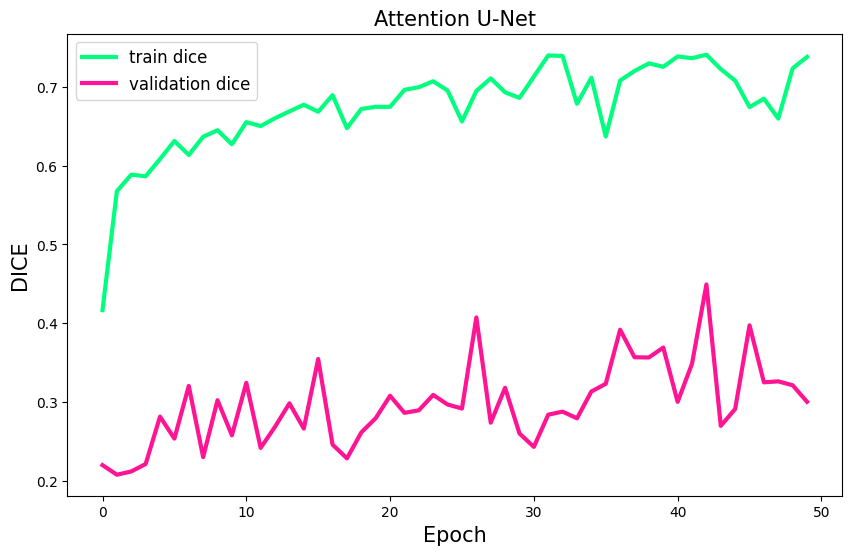

In [ ]:
plot_model_history("Attention U-Net", aun_th, aun_vh, 50)

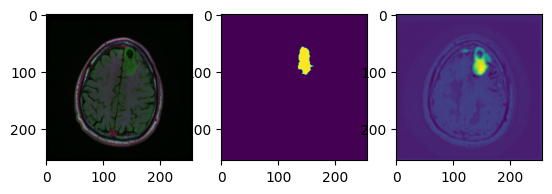

In [ ]:
from PIL import Image
for i, (image, mask) in enumerate(train_loader):
  if i==4:
    break
image=image.to(device)
mask=mask.to(device)
sekil1=image[2].to("cpu").detach().numpy()
sekil2=mask[2].to("cpu").detach().numpy()
mask1=model1(image)
sekil3=mask1[2].to("cpu").detach().numpy()
# sekil=np.reshape(sekil, newshape=[256, 256, 3])
# sekil2=np.reshape(sekil2, newshape=[256, 256, 3])
sekil1 = np.transpose(sekil1, (1, 2, 0))
# sekil2 = np.transpose(sekil2, (1, 2, 0))
# sekil3 = np.transpose(sekil3, (1, 2, 0))
sekil3=np.reshape(sekil3, newshape=[256, 256])
sekil2=np.reshape(sekil2, newshape=[256, 256])

plt.subplot(1,3,1)
plt.imshow(sekil1)
plt.subplot(1,3,2)
plt.imshow(sekil2)
plt.subplot(1,3,3)
plt.imshow(sekil3)
plt.show()

In [ ]:
0#Saving the model
torch.save(model1.state_dict(), '/content/drive/MyDrive/brain_segm/model2.pth')

In [ ]:
model_state_dict = torch.load('/content/drive/MyDrive/brain_segm/model1.pth', map_location='cpu')
saved_model=UNet()
saved_model.load_state_dict(model_state_dict)


<All keys matched successfully>